In [1]:
import pandas as pd

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import ajf_plts
import string

# Setup plotting style

In [2]:
plt.style.reload_library()

plt.style.use(['./ajf_plts/base.mplstyle',
               './ajf_plts/legend_frame.mplstyle'])

# Read in acceleration data

In [3]:
data_file = "./data/line_bridge/Voltage.txt"

with open(data_file, "r") as f:
    _ = f.readline()  # skip heading "channel names:"
    chan_names = f.readline().rstrip().split("\t")

    _ = f.readline()  # skip heading "start times:"
    start_times = f.readline().rstrip().split("\t")

    _ = f.readline()  # skip heading "dt:"
    dt = float(f.readline().rstrip())

raw_data = pd.read_csv(data_file, sep="\t", names=["x", "y", "z"], skiprows=7)

raw_data["t"] = np.arange(len(raw_data)) * dt

chan_sens = 2.0

raw_data[["x", "y", "z"]] /= chan_sens

raw_data.z += 1.0

<AxesSubplot:>

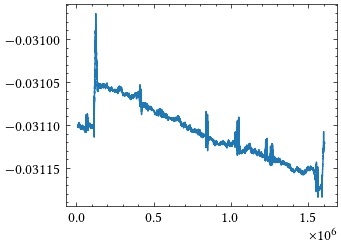

In [4]:
%matplotlib widget
raw_data.x.rolling(10000).mean().plot()

# Extract regions of signal to plot

In [5]:
# At around 80s into the test the accelerometer was knocked out of place
# so for simplicity we cut the first 100s off to avoid plotting across the
# discontinuity in baselines.
# However, we do this after we mask out the regions we want to plot as the
# original timestamps match near perfectly with the video timestamps

time_zero_offset = 100  # seconds

# regions of we want to plot
full_t = (100, 900)
event1_t = (600, 650)
event2_t = (733, 763)

full_mask = raw_data.t.between(*full_t).values
event1_mask = raw_data.t.between(*event1_t).values
event2_mask = raw_data.t.between(*event2_t).values

# now change timestamp origin
data = raw_data.copy().set_index("t")
data.index -= time_zero_offset

# Calculate generalised variance

In [6]:
# find out what speed limit is for trucks on line bridge

v_length = 8.0  # metres
velocity = 20  # metre per second
v_win = v_length / velocity

WIN_LEN = int(v_win / dt)

print("Window length: ", v_win, "secs")

data["gen_var"] = np.linalg.det(
    data[["x", "y", "z"]].rolling(WIN_LEN).cov().values.reshape(-1, 3, 3)
)

Window length:  0.4 secs


/home/ajf/ajf_conda_envs/r_python310/lib/python3.10/site-packages/numpy/linalg/linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


# Plot of all raw acceleration

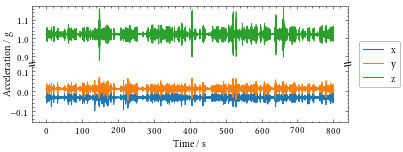

In [7]:
%matplotlib inline

figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)

fig = plt.figure(figsize=figsize)
outer = fig.add_gridspec()

# Acceleration plot with broken axis
gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], hspace=0.05)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax.sharex(ax2)

# plot the same data on both axes
l1 = ax.plot(data[full_mask][["x", "y", "z"]], ls="-")
l2 = ax2.plot(data[full_mask][["x", "y", "z"]], ls="-")

# zoom-in / limit the view to different portions of the data
z_min = data[full_mask].z.min()
z_max = data[full_mask].z.max()
z_range = z_max - z_min
z_lims = [z_min - z_range * 0.05, z_max + z_range * 0.05]

xy_min = data[full_mask][["x", "y"]].min().min()
xy_max = data[full_mask][["x", "y"]].max().max()
xy_mid = (xy_max + xy_min) / 2.0
xy_lims = [xy_mid - z_range * 0.5, xy_mid + z_range * 0.5]


ax.set_ylim(z_lims)  # z channel
ax2.set_ylim(xy_lims)  # most of the data

# hide the spines between ax and ax2
ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = 0.01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

ax_fake = fig.add_subplot(gs[0:2, :], frameon=False)
ax_fake.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
ax_fake.set_xlabel("Time / s")
ax_fake.set_ylabel("Acceleration / g")

ax_fake.legend(l1, ["x", "y", "z"], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig11.pdf')

# GV for overall signal

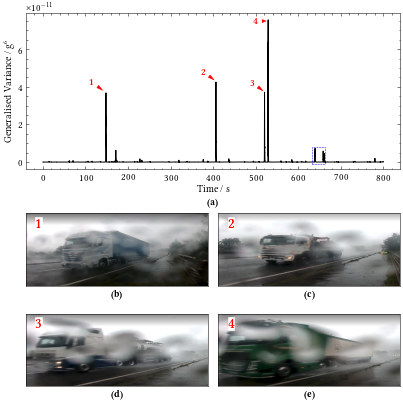

In [8]:
%matplotlib inline

cap_axes = []

figsize = (ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches)
fig = plt.figure(figsize=figsize)

# Overall GV plot
ax = fig.add_subplot(2, 1, 1)

data[full_mask].gen_var.plot(ax=ax, c='k')
ax.set_ylabel(r"Generalised Variance / $\text{g}^6$")
ax.set_xlabel("Time / s")

xlims = list(ax.get_xlim())
ylims = list(ax.get_ylim())

ylims[0] *= 0.3
ylims[1] *= 0.1

annot_kwargs = dict(
    c="r",
    xycoords="data",
    textcoords="offset points",
    arrowprops=dict(color="red", arrowstyle="wedge"),
    horizontalalignment="right",
    verticalalignment="bottom",
)

ax.annotate(r"$\mathbf{1}$", xy=(144, 3.75e-11), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{2}$", xy=(406, 4.3e-11), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{3}$", xy=(521, 3.72e-11), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{4}$", xy=(529.5, 7.5e-11), xytext=(-10, -5), **annot_kwargs)

ax.add_patch(
    mpl.patches.Rectangle(
        (event2_t[0] - time_zero_offset, ylims[0]),  # (x,y)
        event2_t[1] - event2_t[0],  # width
        ylims[1] - ylims[0],  # height
        transform=ax.transData,
        ec="blue",
        ls="--",
        fill=False,
        zorder=2,
    )
)

cap_axes.append(ax)


v_axes = [fig.add_subplot(4, 2, 5 + i) for i in range(4)]

[a.set_xticks([], []) for a in v_axes]
[a.set_yticks([], []) for a in v_axes]

v_axes[0].imshow(mpl.image.imread("./data/line_bridge/line_bridge_vehicle_1.png"), aspect="auto")
v_axes[1].imshow(mpl.image.imread("./data/line_bridge/line_bridge_vehicle_2.png"), aspect="auto")
v_axes[2].imshow(mpl.image.imread("./data/line_bridge/line_bridge_vehicle_3.png"), aspect="auto")
v_axes[3].imshow(mpl.image.imread("./data/line_bridge/line_bridge_vehicle_4.png"), aspect="auto")

ajf_plts.caption_axes(
    cap_axes,
)

ajf_plts.caption_axes(v_axes, start_val=1)

ajf_plts.caption_subplots(
    v_axes,
    v_pos=0.95,
    h_pos=0.05,
    va="top",
    ha="left",
    labels=string.digits,
    label_format=r"$\mathbf{{{}}}$",
    start_val=1,
    kwargs=dict(
        c="r",
        size=14,
        bbox={"color": "white", "pad": 0},
    ),
)


fig.tight_layout(h_pad=-1.0)
ajf_plts.save_fig(fig, 'fig12.pdf')

# Plot of raw acceleration for zoom in region

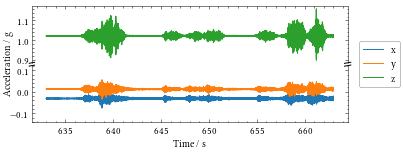

In [9]:
%matplotlib inline

N_ROWS = 1
N_COLS = 1

cap_axes = []

figsize = (ajf_plts.text_width_inches, ajf_plts.fig_height_inches)
fig = plt.figure(figsize=figsize)
outer = fig.add_gridspec(N_ROWS, N_COLS)

row = 0

# Acceleration plot with broken axis
gs = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[0], hspace=0.05)

ax = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])

ax.sharex(ax2)

# plot the same data on both axes
l1 = ax.plot(data[event2_mask][["x", "y", "z"]], ls="-")
l2 = ax2.plot(data[event2_mask][["x", "y", "z"]], ls="-")

# zoom-in / limit the view to different portions of the data
z_min = data[event2_mask].z.min()
z_max = data[event2_mask].z.max()
z_range = z_max - z_min
z_lims = [z_min - z_range * 0.05, z_max + z_range * 0.05]

xy_min = data[event2_mask][["x", "y"]].min().min()
xy_max = data[event2_mask][["x", "y"]].max().max()
xy_mid = (xy_max + xy_min) / 2.0
xy_lims = [xy_mid - z_range * 0.5, xy_mid + z_range * 0.5]


ax.set_ylim(z_lims)  # z channel
ax2.set_ylim(xy_lims)  # most of the data

# hide the spines between ax and ax2
ax.spines["bottom"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

# This looks pretty good, and was fairly painless, but you can get that
# cut-out diagonal lines look with just a bit more work. The important
# thing to know here is that in axes coordinates, which are always
# between 0-1, spine endpoints are at these locations (0,0), (0,1),
# (1,0), and (1,1).  Thus, we just need to put the diagonals in the
# appropriate corners of each of our axes, and so long as we use the
# right transform and disable clipping.

d = 0.01  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color="k", clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)  # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

ax_fake = fig.add_subplot(gs[0:2, :], frameon=False)
ax_fake.tick_params(
    labelcolor="none", which="both", top=False, bottom=False, left=False, right=False
)
ax_fake.set_xlabel("Time / s")
ax_fake.set_ylabel("Acceleration / g")

ax_fake.legend(l1, ["x", "y", "z"], loc="center left", bbox_to_anchor=(1.02, 0.5))

fig.tight_layout()
ajf_plts.save_fig(fig, 'fig13.pdf')

# Plot of generalised variance plus vehicles for zoom in region

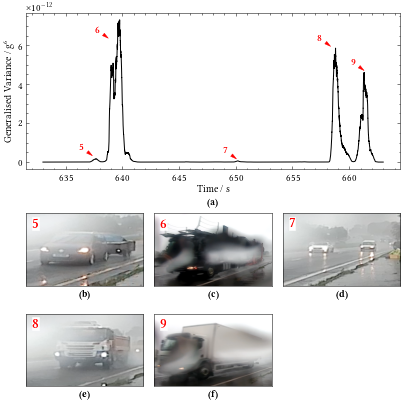

In [10]:
%matplotlib inline

cap_axes = []

figsize = (ajf_plts.text_width_inches, 2.5 * ajf_plts.fig_height_inches)
fig = plt.figure(figsize=figsize)

# Overall GV plot
ax = fig.add_subplot(2, 1, 1)

data[event2_mask].gen_var.plot(ax=ax, c='k')
ax.set_ylabel(r"Generalised Variance / $\text{g}^6$")
ax.set_xlabel("Time / s")

xlims = list(ax.get_xlim())
ylims = list(ax.get_ylim())

ylims[0] *= 0.3
ylims[1] *= 0.1

annot_kwargs = dict(
    c="r",
    xycoords="data",
    textcoords="offset points",
    arrowprops=dict(color="red", arrowstyle="wedge"),
    horizontalalignment="right",
    verticalalignment="bottom",
)

ax.annotate(r"$\mathbf{5}$", xy=(637.5, 2.65e-13), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{6}$", xy=(638.9, 6.3e-12), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{7}$", xy=(650.2, 1e-13), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{8}$", xy=(658.5, 5.88e-12), xytext=(-10, 5), **annot_kwargs)
ax.annotate(r"$\mathbf{9}$", xy=(661.45, 4.64e-12), xytext=(-10, 5), **annot_kwargs)

cap_axes.append(ax)

v_axes = [fig.add_subplot(4, 3, 7 + i) for i in range(5)]

[a.set_xticks([], []) for a in v_axes]
[a.set_yticks([], []) for a in v_axes]

v_axes[0].imshow(mpl.image.imread("./data/line_bridge/12.18.png"), aspect="auto")
v_axes[1].imshow(mpl.image.imread("./data/line_bridge/12.21.png"), aspect="auto")
v_axes[2].imshow(mpl.image.imread("./data/line_bridge/12.30.png"), aspect="auto")  # cars
v_axes[3].imshow(mpl.image.imread("./data/line_bridge/12.38.png"), aspect="auto")
v_axes[4].imshow(mpl.image.imread("./data/line_bridge/12.42.png"), aspect="auto")

ajf_plts.caption_axes(
    cap_axes,
)

ajf_plts.caption_axes(v_axes, start_val=1)

ajf_plts.caption_subplots(
    v_axes,
    v_pos=0.95,
    h_pos=0.05,
    va="top",
    ha="left",
    labels=string.digits,
    label_format=r"$\mathbf{{{}}}$",
    start_val=5,
    kwargs=dict(
        c="r",
        size=14,
        bbox={"color": "white", "pad": 0},
    ),
)


fig.tight_layout(h_pad=-1.0)
ajf_plts.save_fig(fig, 'fig14.pdf')